In [1]:
import polars as pl
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from itertools import groupby
from more_itertools import unzip

from data_split import StratifiedGroupKFold_custom

from jump_portrait.fetch import get_jump_image
from jump_portrait.utils import batch_processing, parallel

from collections.abc import Callable, Iterable
from typing import List

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

%load_ext autoreload
%autoreload 2
from parallel_training import run_train
import conv_model
import custom_dataset

# 1) Loading images and create a pytorch dataset

## a) Load Images using Jump_portrait

In [2]:
metadata_pre = pl.read_csv("target2_eq_moa2_metadata")

In [3]:
#site: 1-9 str
#channel: ER, AGP, Mito, DNA and RNA

Few remarks on Jump_portrait

* In get_jump_image
    - Would be better if instead of broadcasting the error: "More than one site found", a suggestion of correction was given
    - Would be great to enable to pass a list of str instead of just a str. 

* all the parameters of get_jump_image are not ully explained:
    - example ```apply_correction``` vs ```apply_illum```
    - ```compressed```
    - ```staging```
* tqdm takes a lot of space: let's try something from [here](https://stackoverflow.com/questions/41707229/why-is-tqdm-printing-to-a-newline-instead-of-updating-the-same-line), or add a way to disable it.

* Workflow 1 and workflow 2
    - parameter ```corrections``` is not consistently defined which I think is confusing:
      1. corrections = ["Orig"]  # Can also be "Illum"
      2. correction = None # or "Illum"
      

### i) function to overcome error occuring for some instance when calling get_jump_image_iter

In [4]:
def try_function(f: Callable):
    '''
    Wrap a function into an instance which will Try to call the function:
        If it success, return a tuple of function parameters + its results
        If it fails, return the function parameters
    '''
    # This assume parameters are packed in a tuple
    def batched_fn(*item, **kwargs):
        try:
            result = (*item, f(*item, **kwargs))
            
        except:
            result = item

        return result    
    return batched_fn

### ii) function to overcome turn get_jump_image_iter compatible with list and load data in a threaded fashion

In [5]:
def get_jump_image_iter(metadata: pl.DataFrame, channel: List[str], 
                        site:List[str], correction:str=None) -> (pl.DataFrame, List[tuple]): 
    '''
       Load jump image associated to metadata in a threaded fashion.
        ----------
    Parameters: 
        metadata(pl.DataFrame): must have the shape (Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well")
        channel(List[str]): list of channel desired
            Must be in ['DNA', 'ER', 'AGP', 'Mito', 'RNA']
        site(List[str]): list of site desired
            For compound, must be in ['1' - '6']
            For ORF, CRISPR, must be in ['1' - '9']
        correction(str): Must be 'Illum' or None
        ----------
    Return:
        features(pl.DataFrame): DataFrame collecting the metadata, channel, site, correction + the image
        work_fail(List(tuple): List collecting tuple of metadata which failed to load an image
        
    '''
    iterable = [(*metadata.row(i), ch, s, correction)
               for i in range(metadata.shape[0]) for s in site for ch in channel]
    img_list = parallel(iterable, batch_processing(try_function(get_jump_image)))
    
    img_list = sorted(img_list, key=lambda x: len(x))
    fail_success = {k: list(g) for k, g in groupby(img_list, key=lambda x: len(x))}
    if len(fail_success) == 1:
        img_success = list(fail_success.values())[0]
        work_fail = []
    else: 
        work_fail, img_success = fail_success.values()
    features = pl.DataFrame(img_success, 
                               schema=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well",
                                        "channel", "site", "correction",
                                        "img"])
    return features, work_fail

In [6]:
features_pre, work_fail = get_jump_image_iter(metadata_pre.select(pl.col(["Metadata_Source", "Metadata_Batch", 
                                                                               "Metadata_Plate", "Metadata_Well"])),
                                                        channel=['DNA'],#, 'ER', 'AGP', 'Mito', 'RNA'],
                                                        site=[str(i) for i in range(1, 7)],
                                                        correction=None) #None, 'Illum'










  0%|          | 0/24 [00:00<?, ?it/s]







  0%|          | 0/24 [00:00<?, ?it/s]















  0%|          | 0/24 [00:00<?, ?it/s]











  0%|          | 0/24 [00:00<?, ?it/s]


  0%|          | 0/24 [00:00<?, ?it/s]










  0%|          | 0/24 [00:00<?, ?it/s]

















  0%|          | 0/24 [00:00<?, ?it/s]



  0%|          | 0/24 [00:00<?, ?it/s]


















 ... (more hidden) ...






  0%|          | 0/24 [00:00<?, ?it/s]
















  0%|          | 0/24 [00:00<?, ?it/s]









  0%|          | 0/24 [00:00<?, ?it/s]













  0%|          | 0/24 [00:00<?, ?it/s]





  0%|          | 0/24 [00:00<?, ?it/s]














  0%|          | 0/24 [00:00<?, ?it/s]












  0%|          | 0/24 [00:00<?, ?it/s]




  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]















  4%|▍         | 1/24 [00:00<00:22,  1.04it/s]



  4%|▍         | 1/24 [00:01<00:24,  1.05s/it]


  4%|▍         | 1/24 [00:01

### iii) Add 'site' 'channel' and filter out sample which could not be load (using join)

In [7]:
metadata = metadata_pre.join(features_pre.select(pl.all().exclude(["correction", "img"])),
              on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
              how="inner").sort(by=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "site"])

metadata = metadata.with_columns(pl.arange(0,len(metadata)).alias("ID"))
features = features_pre.join(metadata.select(pl.col(["Metadata_Source", "Metadata_Batch", 
                                                 "Metadata_Plate", "Metadata_Well", "site", "ID"])),
                         on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", 
                             "Metadata_Well", "site"],
                         how="inner").sort(by="ID")

## b) Visualisation of some images

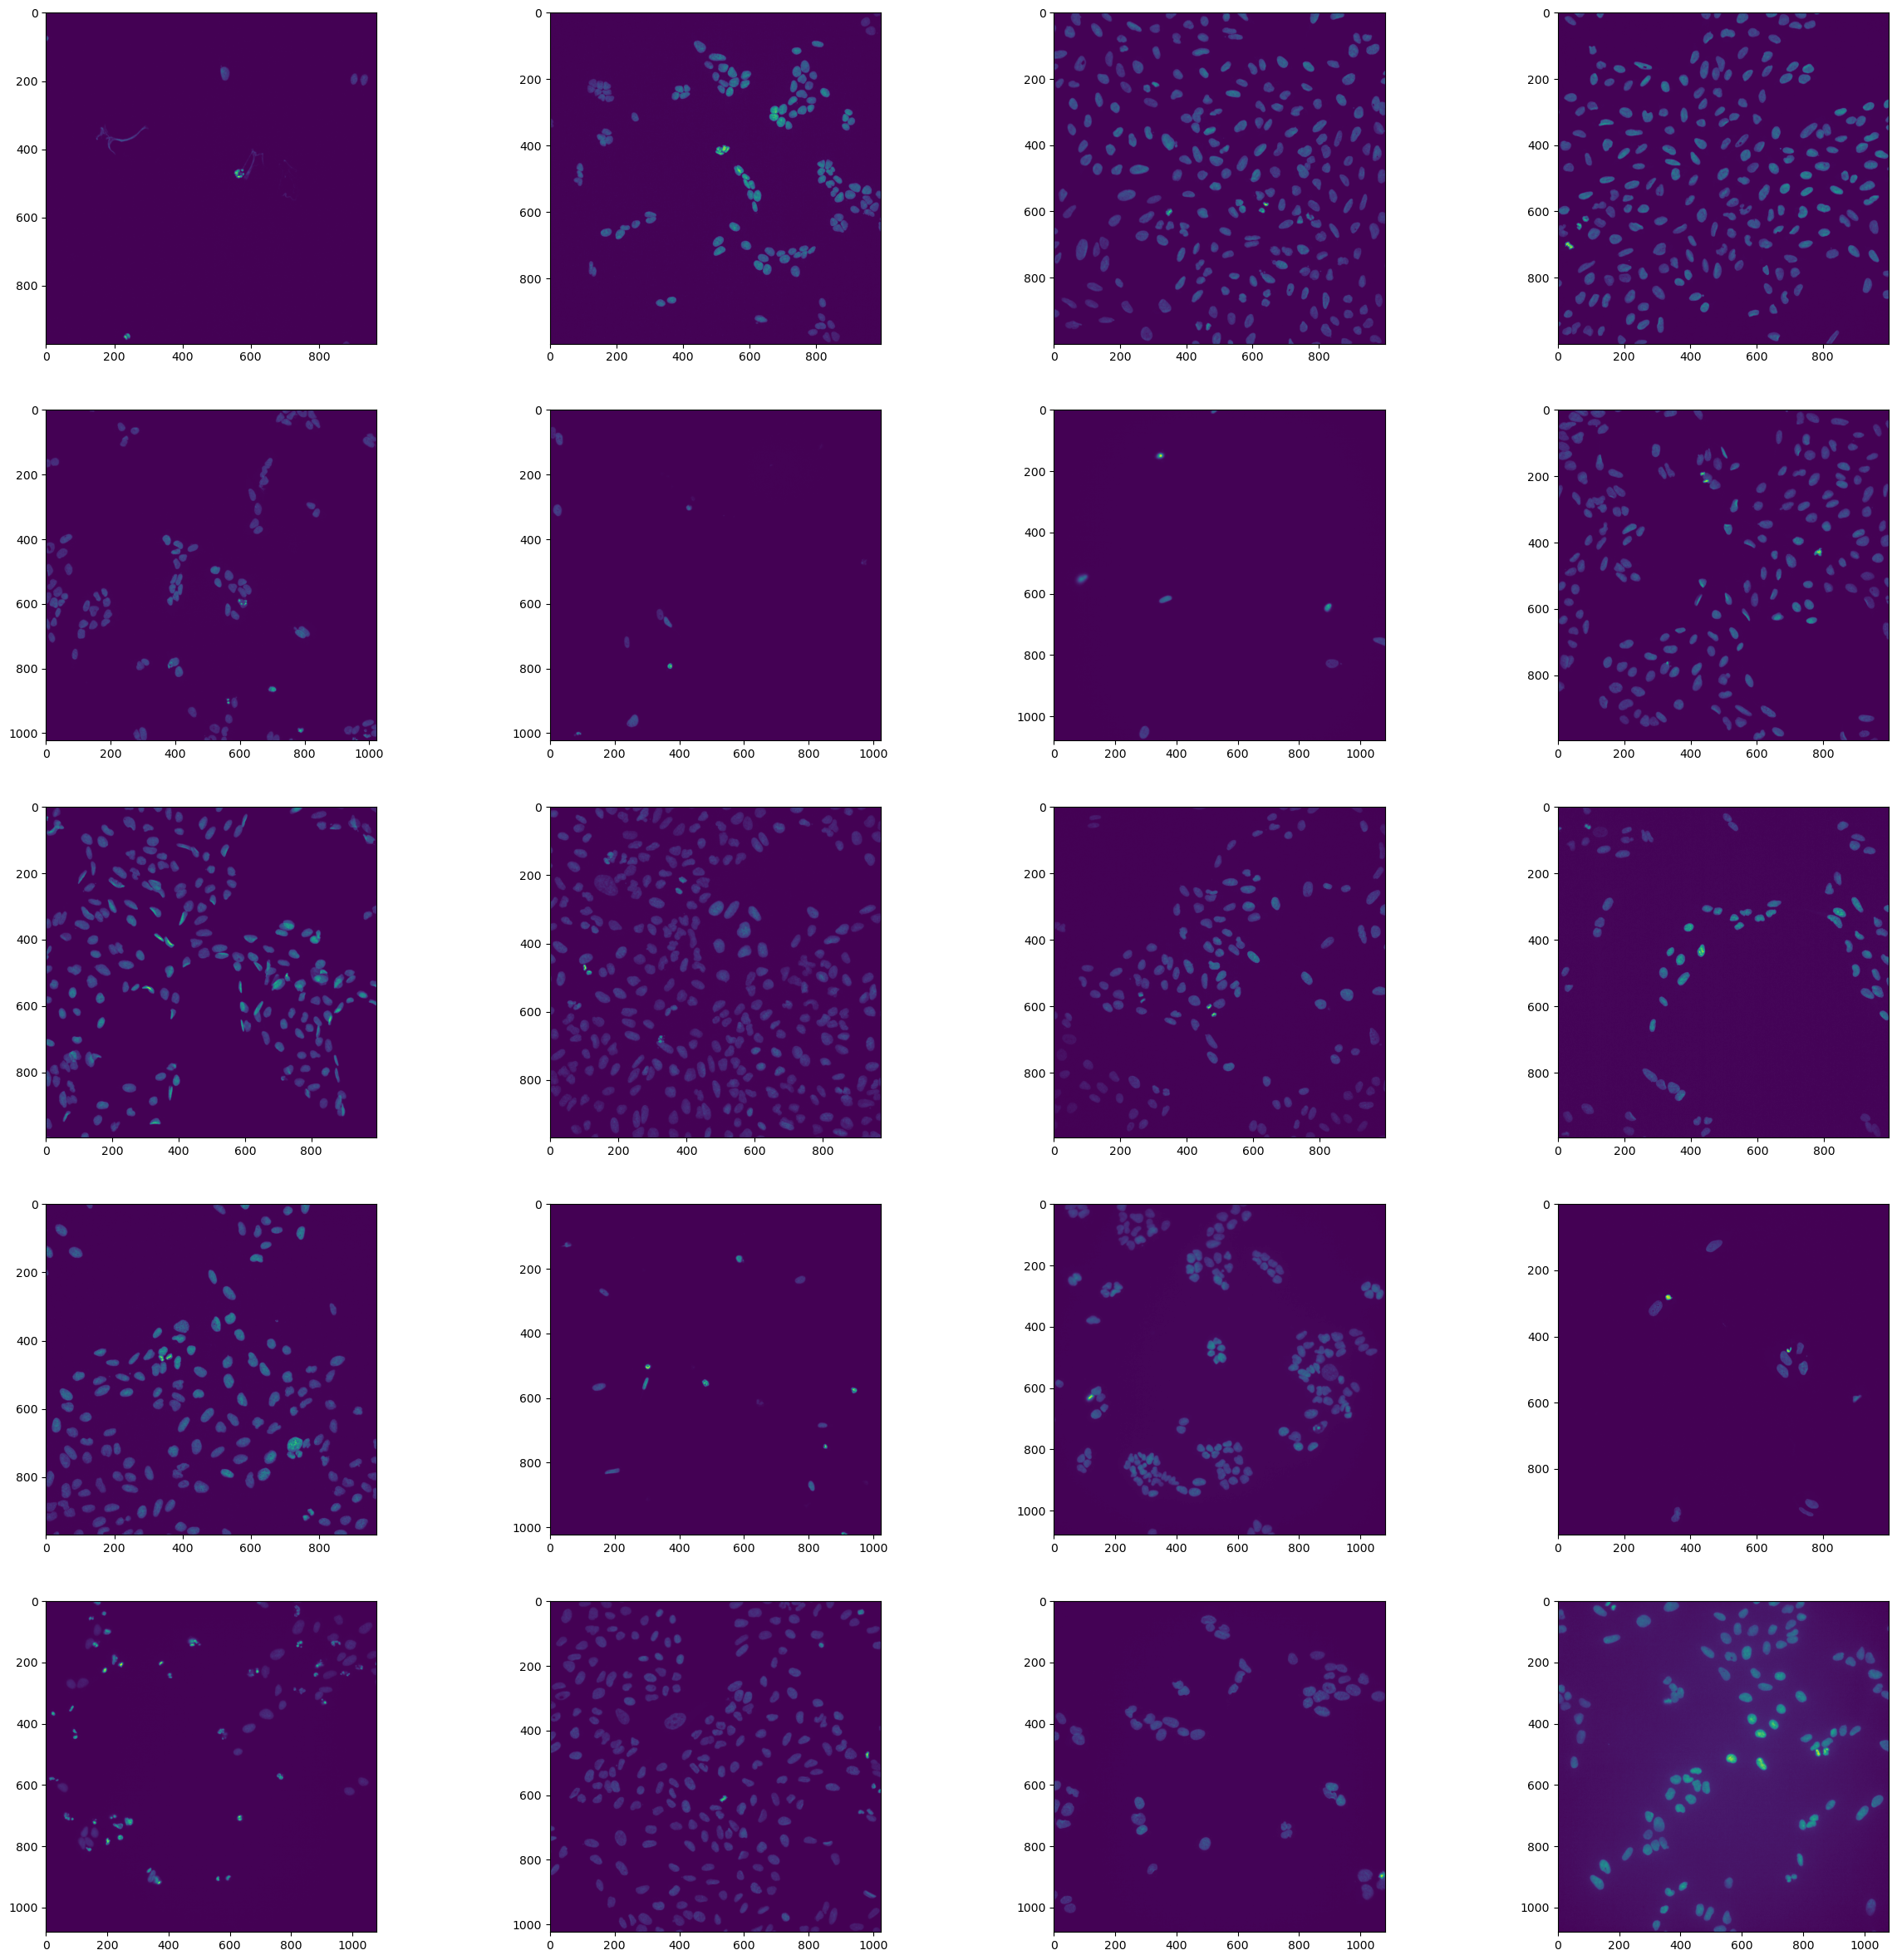

In [8]:
fig, axes = plt.subplots(5, 4, figsize=(30,30))
axes = axes.flatten()
select = np.random.randint(0, len(features), (20))
for i in range(20):
    axes[i].imshow(features["img"][int(select[i])])

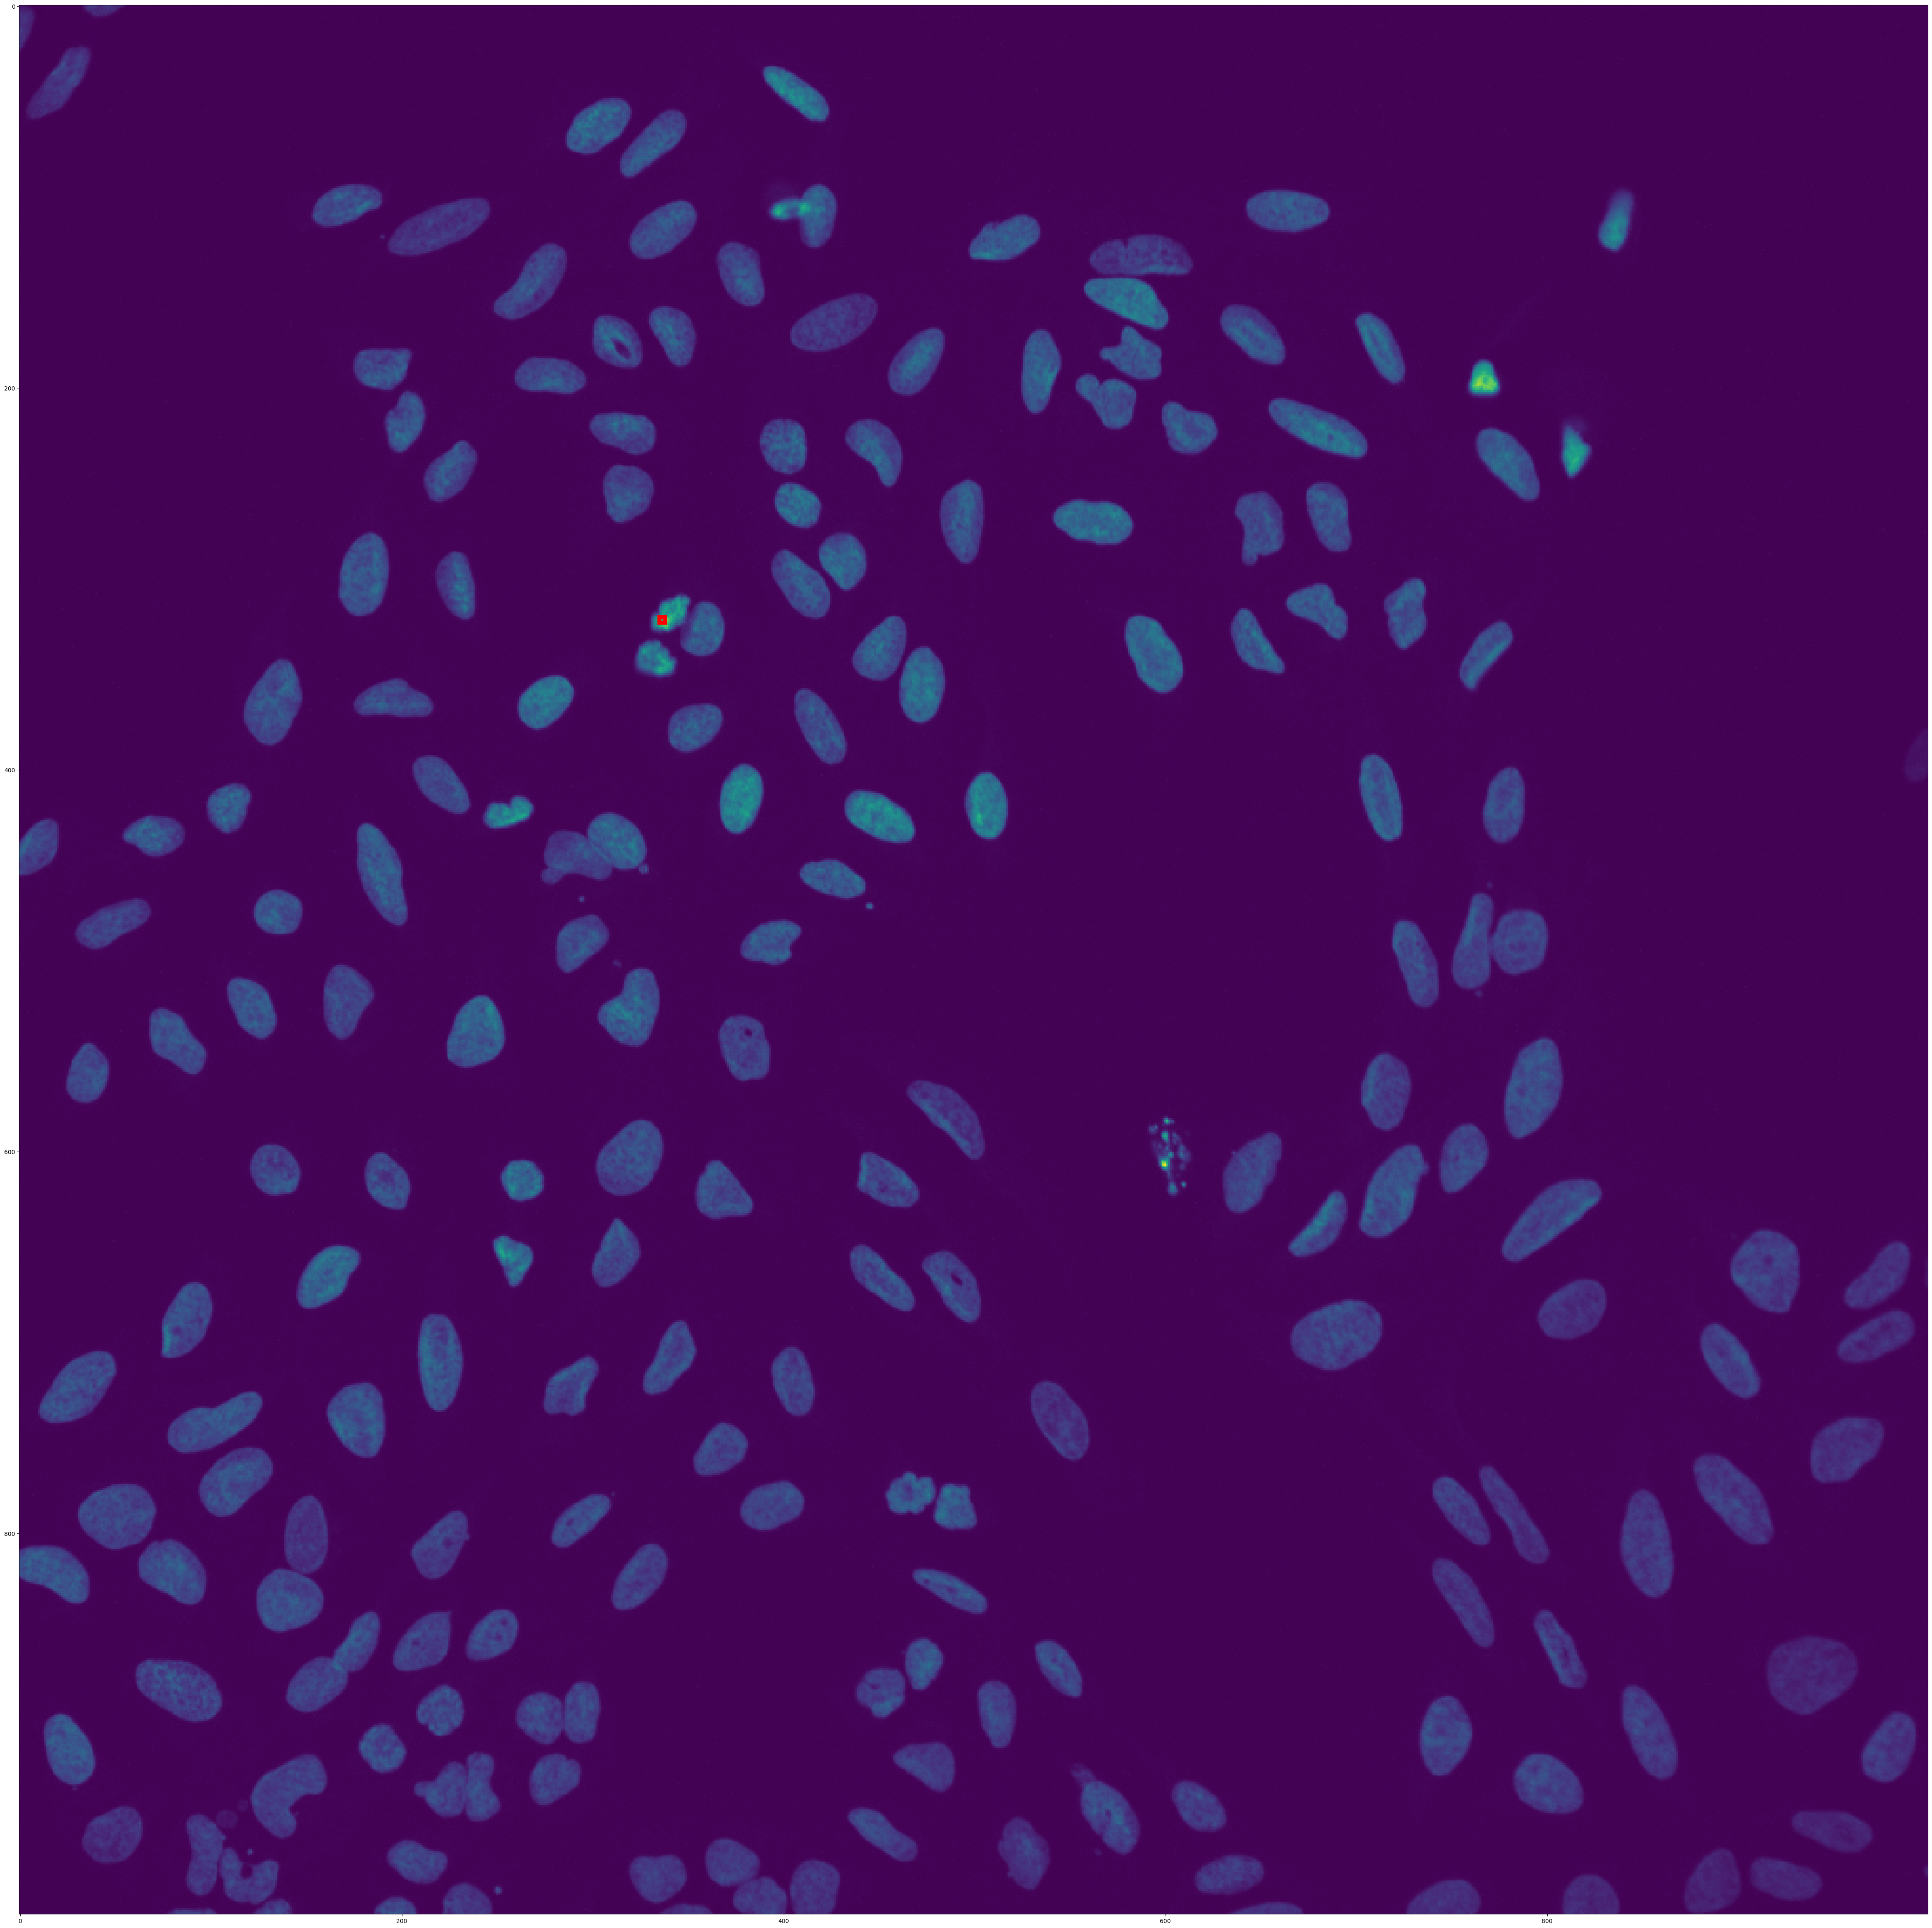

In [9]:
#Visualisation of the chosen kernel size relative to the image size
fig, axes = plt.subplots(1, 1, figsize=(60,60))
axes.imshow(features["img"][1]-features["img"][1].min())
rect = patches.Rectangle((335, 320), 3, 3, linewidth=7, edgecolor='r', facecolor='none')
axes.add_patch(rect)

## c) Resize images

In [10]:
shape_image = list(map(lambda x: x.shape, features["img"].to_list()))
shape_image.sort(key=lambda x:x[0])
shape_image_count = {k: shape_image.count(k) for k in set(shape_image)}
shape_image_count

{(1080, 1080): 1266,
 (1000, 1000): 654,
 (996, 996): 676,
 (998, 998): 726,
 (970, 970): 690,
 (1024, 1024): 636}

In [11]:
def crop_square_array(x, des_size):
    h, w = x.shape
    h_off, w_off = (h-des_size)//2, (w-des_size)//2
    return x[h_off:des_size+h_off,w_off:des_size+w_off]

In [12]:
image_resized = np.array(list(map(lambda x: crop_square_array(x, shape_image[0][0]), features["img"].to_list())))

In [13]:
metadata_df = metadata.to_pandas().set_index(keys="ID")
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa"]))
labels, groups = metadata_df["moa_id"].values, metadata_df["Metadata_InChIKey"].values

### d) Create the pytorch dataset withrespect to kfold split

### i) Custom dataset

In [14]:
class ImageDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None):
        super().__init__()
        self.imgs = imgs
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx): 
        return self.imgs[idx,:,:], self.img_labels[idx]

### ii) Data split

In [15]:
kfold = list(StratifiedGroupKFold_custom().split(image_resized, labels, groups))

In [16]:
image_resized_tensor = torch.unsqueeze(torch.tensor(image_resized, dtype=torch.float), 1)
labels_tensor = torch.tensor(labels, dtype=torch.long)
dataset_fold = {i: {"train": custom_dataset.ImageDataset(image_resized_tensor[kfold[i][0]], labels_tensor[kfold[i][0]]),
     "test": custom_dataset.ImageDataset(image_resized_tensor[kfold[i][1]], labels_tensor[kfold[i][1]])}
 for i in range(len(kfold))}

# 2) Model

In [17]:
class VGG(nn.Module):
    def __init__(self, img_depth, img_size, lab_dim, n_conv_block, n_conv_list, n_lin_block):
        super().__init__()
        self.img_depth = img_depth
        self.img_size = img_size
        self.img_size = img_size
        self.lab_dim = lab_dim
        self.n_conv_block = n_conv_block
        self.n_conv_list = n_conv_list
        self.n_lin_block = n_lin_block
        self.fc_dim = 12 * (2 ** (self.n_conv_block - 1)) * ((self.img_size // (2 ** self.n_conv_block)) ** 2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        self.sequence = nn.Sequential(
                        *[self.conv_block((12 * (2 ** (i-1)) if i != 0 else self.img_depth),
                                          (12 * (2 ** i) if i!=0 else 12),
                                          self.n_conv_list[i])
                                     for i in range(self.n_conv_block)],
                        nn.Flatten(),
                        *[self.linear_block(self.fc_dim // (4 ** i), self.fc_dim // (4 ** (i + 1)))
                          for i in range(self.n_lin_block - 1)],
                        nn.Linear(self.fc_dim // (4 ** (self.n_lin_block - 1)), self.lab_dim))
        
    def conv_block(self, in_ch, out_ch, num_conv):
        return nn.Sequential(
            *sum([(nn.Conv2d(in_channels=(in_ch if i==0 else out_ch), out_channels=out_ch, 
                             kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(out_ch),
                   self.relu)
              for i in range(num_conv)], ()),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

    def linear_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=out_dim),
            self.relu,
            self.drop
        )

    def forward(self, x):
        return self.sequence(x)

In [18]:
vgg = VGG(img_depth=1, 
          img_size=970, 
          lab_dim=7, 
          n_conv_block=6, 
          n_conv_list=[2 for _ in range(6)], 
          n_lin_block=3)

In [19]:
param_size = 0
for param in vgg.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in vgg.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))

model size: 7574.48MB


In [20]:
free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
print(f"Free memory in cuda 0 before model load: {free_mem / 1024**2:.2f} MB")
free_mem = torch.cuda.get_device_properties(1).total_memory - torch.cuda.memory_allocated(1)
print(f"Free memory in cuda 1 before model load: {free_mem / 1024**2:.2f} MB")

Free memory in cuda 0 before model load: 48647.56 MB
Free memory in cuda 1 before model load: 48669.75 MB


In [21]:
total_size = 0
for i in range(len(dataset_fold[0]["train"][:100])):
    sample = dataset_fold[0]["train"][i]
    sample_size = 0
    if isinstance(sample, tuple):
        for item in sample:
            if isinstance(item, torch.Tensor):
                sample_size += item.element_size() * item.nelement()
    total_size += sample_size

print(f"Total dataset size: {total_size / (1024 ** 2):.2f} MB")

Total dataset size: 7.18 MB


### No need for parallel model
### Let's however speed up training by taking advantage of the 2 GPU. 

# 3) Trainer

## b) DistributedDataParallel

In [ ]:
run_train(model=conv_model.VGG, 
          model_param=(1, #img_depth
                       970, #img_size
                       7, #lab_dim
                       6, #n_conv_block
                       [2, 2, 2, 2, 2, 2], #n_conv_list
                       3), #n_lin_block
          adam_param={"lr": 1e-3,
                      "weight_decay":0}, 
          dataset=dataset_fold[0]["train"],
          batch_size=16, 
          epochs=100, 
          log_interval=1, 
          fold=0)

[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
  1%|          | 1/100 [01:54<3:08:40, 114.35s/it]

In [23]:
model_trained = conv_model.VGG(1, #img_depth
                       970, #img_size
                       7, #lab_dim
                       6, #n_conv_block
                       [2, 2, 2, 2, 2, 2], #n_conv_list
                       3)
model_trained.load_state_dict(torch.load("ddp_trained_model_fold_0.pth"))
model_trained.eval()

VGG(
  (relu): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
  (sequence): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2,

In [27]:
torch.argmax(nn.Softmax(dim=1)(model_trained(dataset_fold[0]["train"][:10][0])), dim=1) #Looks to have learn something

tensor([4, 0, 6, 0, 0, 1, 2, 4, 1, 4])

In [26]:
dataset_fold[0]["train"][:10][1]

tensor([2, 0, 6, 0, 0, 1, 2, 4, 1, 5])

In [ ]:
def eval_classifier(feat_table, metadata, n_splits, seed, 
                    classifier,
                    classifier_params,
                    splitter_method,
                    drop_corr=True, # True, False
                    scaler=None, #None, 'group', 'standard'
                    rev_order=False,
                    roc_per_class=False, 
                    group="Metadata_Source"): # True, False  
    
    y_target, groups =  metadata["moa_id"], metadata[group]
    
    # Initialize the Classifier
    classifier = classifier(**classifier_params)
    
    # Initialize Stratified K-Fold cross-validator
    splitter = splitter_method(n_splits=n_splits, shuffle=True, random_state=seed)

    # Build Pipeline
    pipe_list = []
    if drop_corr == True:
        if cp.cuda.is_available():
            pipe_list.append(('drop_corr', features_drop_corr_gpu()))
        else:
            pipe_list.append(('drop_corr', features_drop_corr()))
    if scaler is not None:
        if scaler == 'group':
            pipe_list.append(('scaler', StandardScaler_group(groups)))
        elif scaler == 'standard':
            pipe_list.append(('scaler', StandardScaler_pandas()))

    if rev_order == True:
        pipe_list = pipe_list[::-1]

    pipe_list.append(('classifier', classifier))
    
    pipe = Pipeline(pipe_list)
    
    # Lists to store precision-recall auc score, train and test accuracy for each fold
    train_auc_fold = []
    test_auc_fold = []
    test_f1_fold = []
    
    n_class = np.unique(y_target).shape[0]
    keep_trac_test_error = np.zeros((n_class, n_class))

    # Perform stratified k-fold cross-validation

    for train_index, test_index in tqdm(splitter.split(feat_table, y_target, groups)):
        X_train, X_test = feat_table.loc[train_index], feat_table.loc[test_index]
        y_train, y_test = y_target.loc[train_index], y_target.loc[test_index]

        # Fit the classifier on training data
        pipe.fit(X_train, y_train)
        
        # Predict probabilities of the positive class for train and test data
        y_train_scores = pipe.predict_proba(X_train)  # Train set
        y_test_scores = pipe.predict_proba(X_test)    # Test set
        y_test_pred = pipe.predict(X_test)
        
        y_train_score_expanded, train_label_expanded = expanded_score(y_train, y_train_scores, pipe.classes_)
        y_test_score_expanded, test_label_expanded = expanded_score(y_test, y_test_scores, pipe.classes_)

        #print(y_train, y_test)
        # Compute ROC_AUC for train and test set
        
        if roc_per_class == False: 
            average = "macro"
        else: 
            average = None
            for i, j in zip(y_test.values, np.argmax(y_test_score_expanded, axis=1)):
                keep_trac_test_error[i][j] += 1  

           
        train_auc = roc_auc_score(y_train, y_train_score_expanded,
                                  multi_class="ovr",
                                  average=average,
                                  labels=train_label_expanded)

        test_auc = roc_auc_score(y_test, y_test_score_expanded,
                                 multi_class="ovr",
                                 average=average,
                                 labels=test_label_expanded)
        
        test_f1 = f1_score(y_test, y_test_pred, 
                           average="macro")
                           
        
        
        if roc_per_class == False:
            print(train_auc, test_auc, test_f1)
        # Append train and test accuracy, train and test AUC score to respective lists
        train_auc_fold.append(train_auc)
        test_auc_fold.append(test_auc)
        test_f1_fold.append(test_f1)
    
    # Average metrics across all folds
    mean_train_auc = np.mean(train_auc_fold)
    mean_test_auc = np.mean(test_auc_fold)
    mean_test_f1 = np.mean(test_f1_fold)